# Analysis of Mammographic Mass Dataset

**Source:**
Matthias Elter
Fraunhofer Institute for Integrated Circuits (IIS)
Image Processing and Medical Engineering Department (BMT)
Am Wolfsmantel 33
91058 Erlangen, Germany
matthias.elter '@' iis.fraunhofer.de
(49) 9131-7767327 

Prof. Dr. Rüdiger Schulz-Wendtland
Institute of Radiology, Gynaecological Radiology, University Erlangen-Nuremberg
Universitätsstraße 21-23
91054 Erlangen, Germany

https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass

**Dataset Information**

Mammography is the most effective method for breast cancer screening
available today. However, the low positive predictive value of breast
biopsy resulting from mammogram interpretation leads to approximately
70% unnecessary biopsies with benign outcomes. To reduce the high
number of unnecessary breast biopsies, several computer-aided diagnosis
(CAD) systems have been proposed in the last years.These systems
help physicians in their decision to perform a breast biopsy on a suspicious
lesion seen in a mammogram or to perform a short term follow-up
examination instead.
This data set can be used to predict the severity (benign or malignant)
of a mammographic mass lesion from BI-RADS attributes and the patient's age.
It contains a BI-RADS assessment, the patient's age and three BI-RADS attributes
together with the ground truth (the severity field) for 516 benign and
445 malignant masses that have been identified on full field digital mammograms
collected at the Institute of Radiology of the
University Erlangen-Nuremberg between 2003 and 2006.
Each instance has an associated BI-RADS assessment ranging from 1 (definitely benign)
to 5 (highly suggestive of malignancy) assigned in a double-review process by
physicians. Assuming that all cases with BI-RADS assessments greater or equal
a given value (varying from 1 to 5), are malignant and the other cases benign,
sensitivities and associated specificities can be calculated. These can be an
indication of how well a CAD system performs compared to the radiologists.

Class Distribution: benign: 516; malignant: 445 

**Attribute Information**

6 Attributes in total (1 goal field, 1 non-predictive, 4 predictive attributes)

1. BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)
2. Age: patient's age in years (integer)
3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6. Severity: benign=0 or malignant=1 (binominal, goal field!) 

**Importing the Libraries**

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from IPython.core.pylabtools import figsize
from scipy.stats import zscore
from scipy import stats
from numpy import percentile
import sweetviz as sw
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from yellowbrick.classifier import ClassificationReport
from yellowbrick.datasets import load_occupancy
from sklearn.metrics import f1_score

# Data Preprocessing

The dataset was in .dat format, so I had to convert to .csv. Interestingly, instead of NaN, there were some '?' values, which may be considered as missing values and had to be dealt accordingly. 

In [2]:
df = pd.read_csv("mammography.csv", na_values='?')

In [3]:
df.head()

,5,67,3,5.1,3.1,1
0,4.0,43.0,1.0,1.0,NaN,1
1,5.0,58.0,4.0,5.0,3.0,1
2,4.0,28.0,1.0,1.0,3.0,0
3,5.0,74.0,1.0,5.0,NaN,1
4,4.0,65.0,1.0,NaN,3.0,0


In [4]:
df.columns = ['Assessment', 'Age', 'Shape', 'Margin', 'Density', 'Severity']

In [5]:
df.head()

,Assessment,Age,Shape,Margin,Density,Severity
0,4.0,43.0,1.0,1.0,NaN,1
1,5.0,58.0,4.0,5.0,3.0,1
2,4.0,28.0,1.0,1.0,3.0,0
3,5.0,74.0,1.0,5.0,NaN,1
4,4.0,65.0,1.0,NaN,3.0,0


In [6]:
df.shape

(960, 6)

So, we have 6 columns ("Severity" is the target column - benign or malign)  and 960 separate data rows. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Assessment  958 non-null    float64
 1   Age         955 non-null    float64
 2   Shape       929 non-null    float64
 3   Margin      912 non-null    float64
 4   Density     884 non-null    float64
 5   Severity    960 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 45.1 KB


In [8]:
df.isnull().sum()

Assessment     2
Age            5
Shape         31
Margin        48
Density       76
Severity       0
dtype: int64

This is a decision point about handling the **missing values**. Data is a valuable asset so it may not be the best practice to drop rows easily. Replacing missing values instead of dropping may be an alternative. 

https://machinelearningmastery.com/handle-missing-data-python/

**Assessment** and **Age** have just a few missing values, so different missing value strategies may be needed for different columns.   

**Density** column is highly imbalanced, so mode value (3) can be used to replace the missing values for this column.

Rows with NaN values in **Shape** and **Margin** are deleted.

In [9]:
df.Shape.value_counts()

4.0    400
1.0    224
2.0    211
3.0     94
Name: Shape, dtype: int64

In [10]:
df.Density.value_counts()

3.0    797
2.0     59
1.0     16
4.0     12
Name: Density, dtype: int64

In [11]:
df.Margin.value_counts()

1.0    357
4.0    280
5.0    135
3.0    116
2.0     24
Name: Margin, dtype: int64

In [12]:
df['Density'].fillna(3.0, inplace=True)

In [13]:
df = df.dropna()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885 entries, 0 to 959
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Assessment  885 non-null    float64
 1   Age         885 non-null    float64
 2   Shape       885 non-null    float64
 3   Margin      885 non-null    float64
 4   Density     885 non-null    float64
 5   Severity    885 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 48.4 KB


# Exploratory Data Analysis

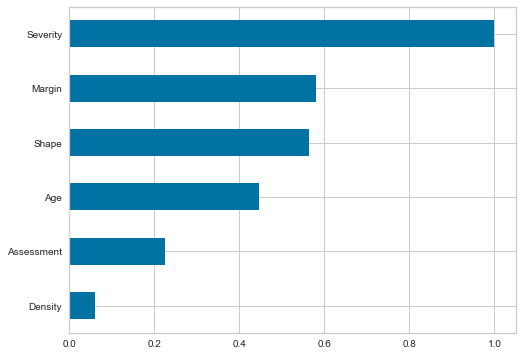

In [16]:
df.corr()['Severity'].sort_values().plot.barh(figsize=(8,6));

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Assessment,885.0,4.369492,1.836710,0.0,4.0,4.0,5.0,55.0
Age,885.0,55.412429,14.664208,18.0,45.0,57.0,66.0,96.0
Shape,885.0,2.743503,1.243433,1.0,2.0,3.0,4.0,4.0
Margin,885.0,2.760452,1.570088,1.0,1.0,3.0,4.0,5.0
Density,885.0,2.920904,0.340454,1.0,3.0,3.0,3.0,4.0
Severity,885.0,0.472316,0.499515,0.0,0.0,0.0,1.0,1.0


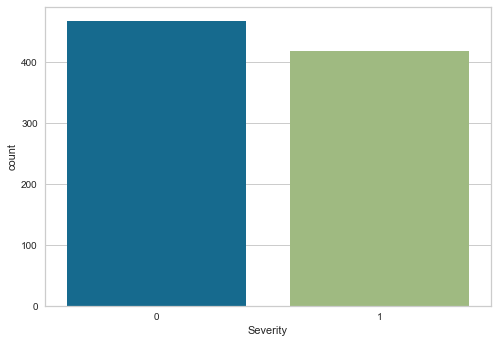

In [18]:
sns.countplot(x='Severity', data = df);

Dataset is **balanced.**

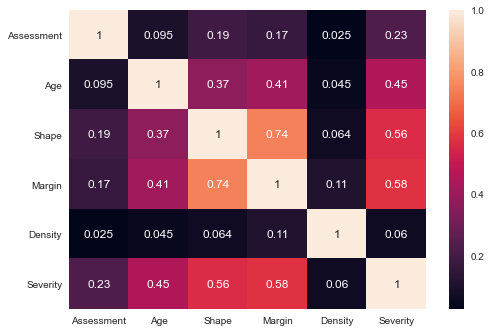

In [20]:
sns.heatmap(df.corr(), annot = True);

According to the Heatmap, **Margin** and **Shape** columns have the highest correlation with Severity, followed by **Age**.

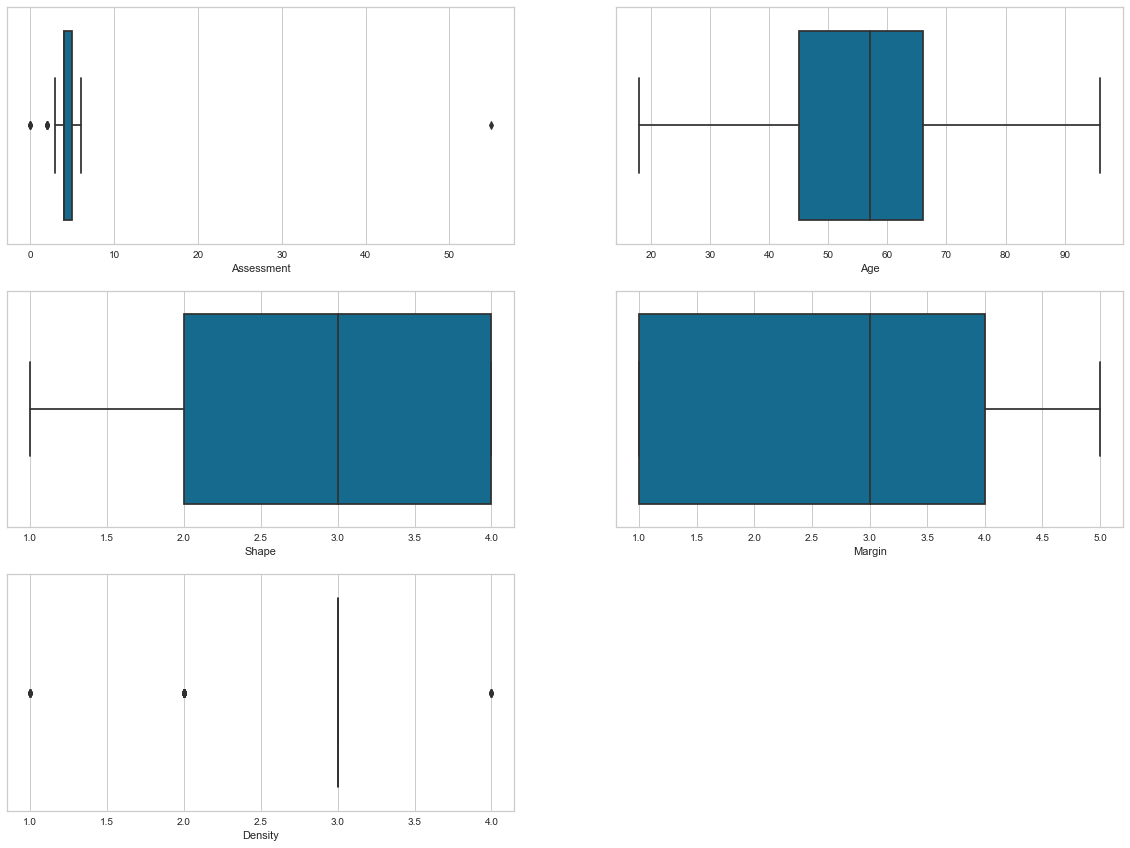

In [23]:
cols = ['Assessment', 'Age', 'Shape',
       'Margin', 'Density']
fig = plt.figure(figsize=(20,20))       
for col in range(len(cols)):
    fig.add_subplot(4,2,col+1)
    sns.boxplot(x=df.iloc[ : , col])
plt.show()

In [25]:
report = sw.analyze(df)

                                             |                                             | [  0%]   00:00 ->…

In [26]:
report.show_html('eda_report_task.html')

Report eda_report_task.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Also, **SweetViz** report is generated. Sweetviz may be considered as an **automated powerful EDA** in Python.

Additionally, **AutoViz** report is generated. Sweetviz may be considered as an **automated powerful EDA** in Python.

Shape of your Data Set: (885, 6)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  5
    Number of Integer-Categorical Columns =  0
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    5 Predictors classified...
        This does not include the Target column(s)
        No variables removed since no ID or low-information variables found in data set

################ Binary_Classification VISUALIZATION Started #####################


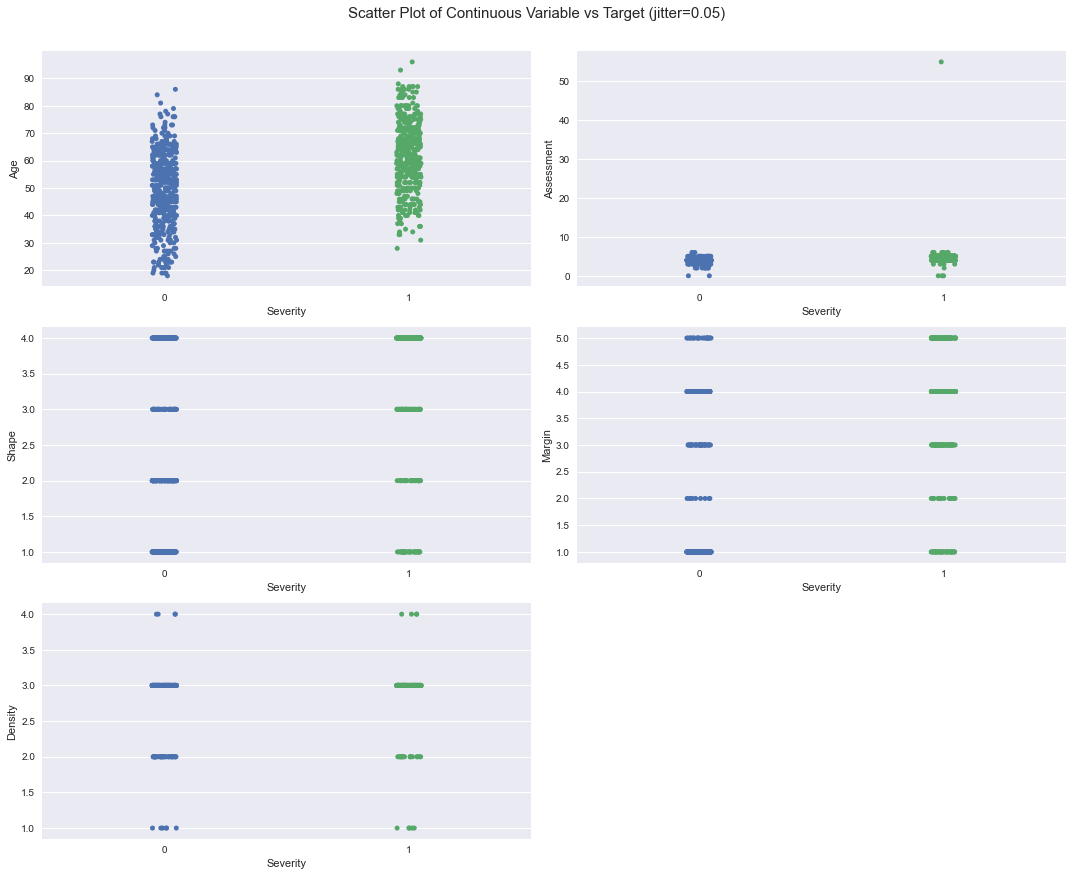

Total Number of Scatter Plots = 15


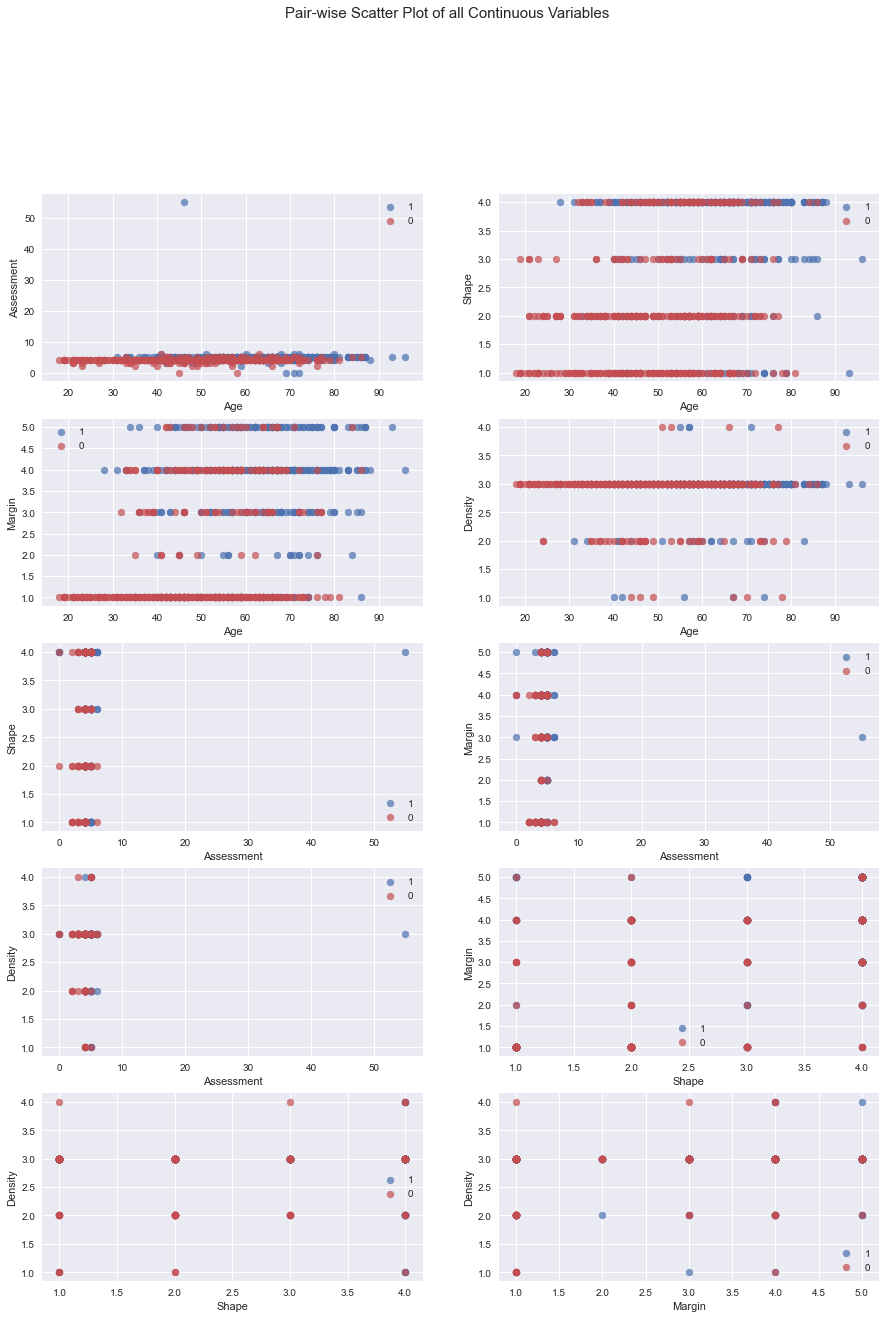

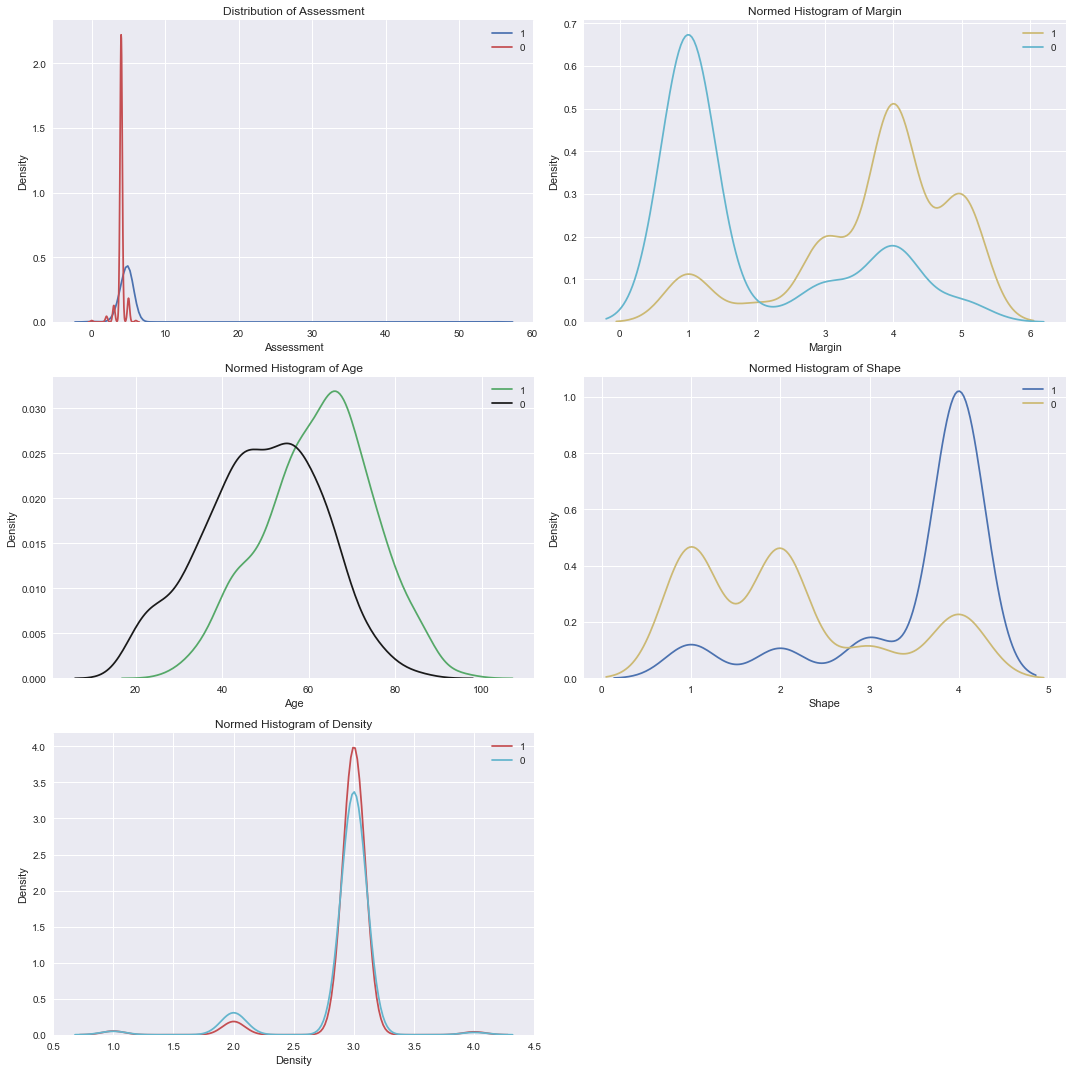

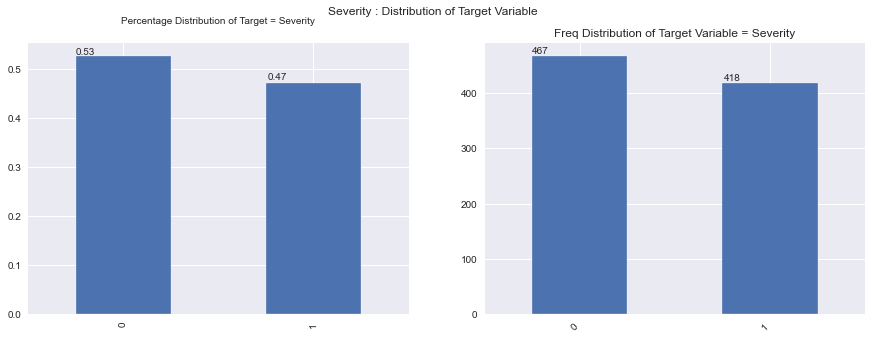

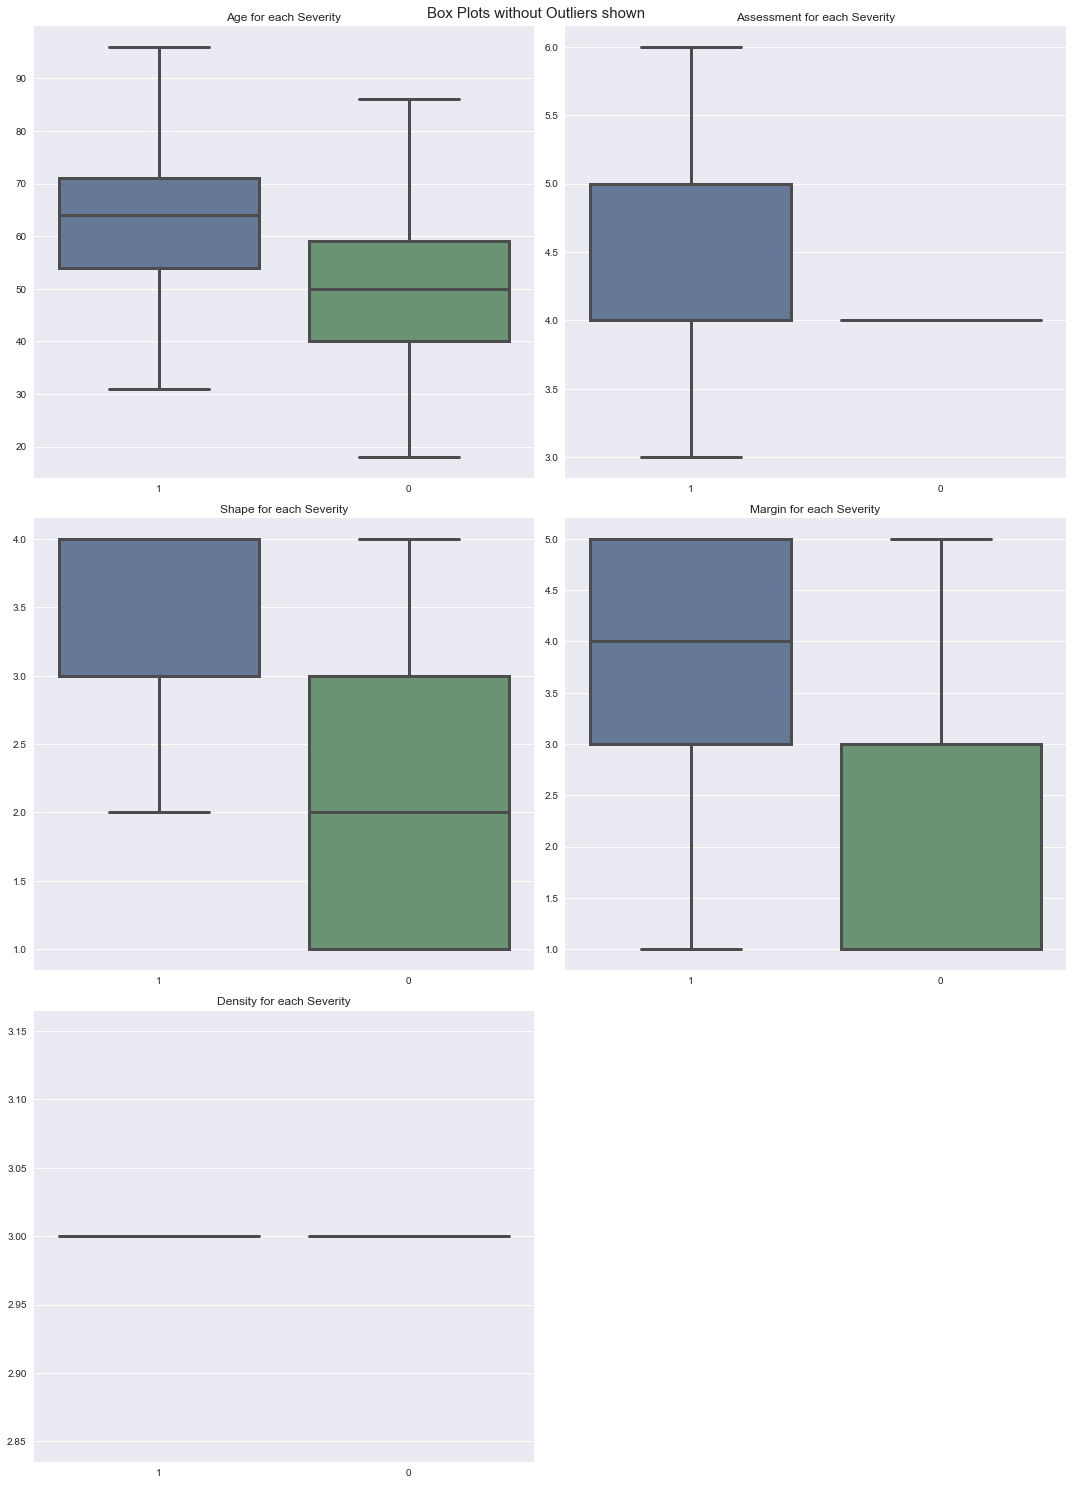

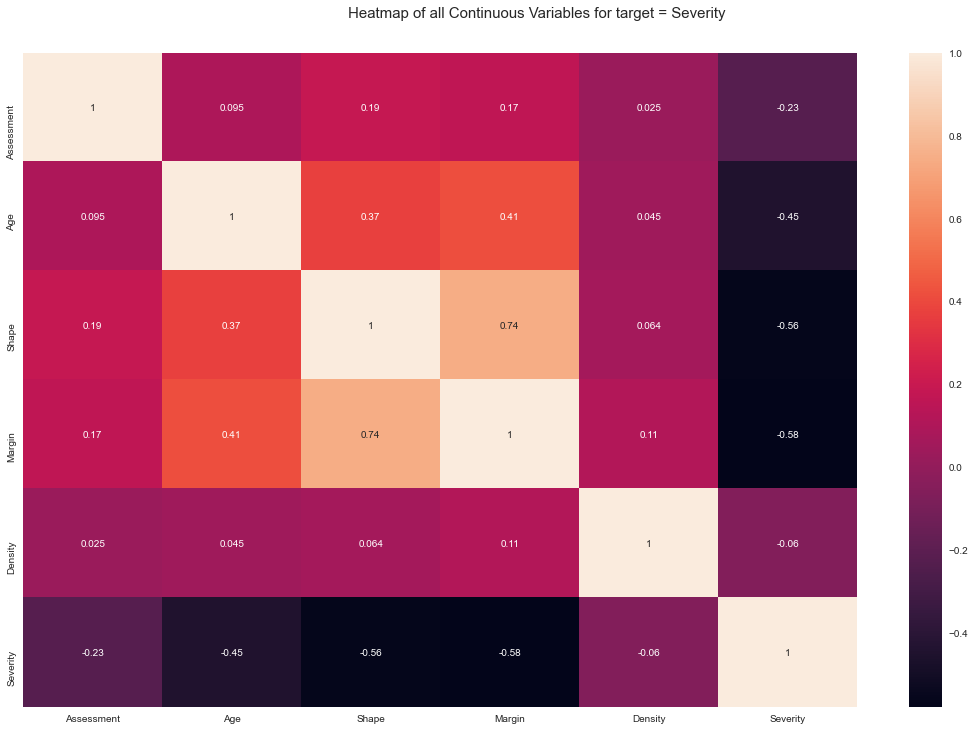

No categorical or boolean vars in data set. Hence no pivot plots...
No categorical or numeric vars in data set. Hence no bar charts.
Time to run AutoViz (in seconds) = 5.232

 ###################### VISUALIZATION Completed ########################


In [31]:
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()
filename = ""
sep = ","
dft = AV.AutoViz(
    filename,
    sep=",",
    depVar="Severity",
    dfte=df,
    header=0,
    verbose=0,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=30,
)

# Train - Test - Split

In [32]:
X = df.drop("Severity",axis=1)
y = df["Severity"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 708 entries, 450 to 124
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Assessment  708 non-null    float64
 1   Age         708 non-null    float64
 2   Shape       708 non-null    float64
 3   Margin      708 non-null    float64
 4   Density     708 non-null    float64
dtypes: float64(5)
memory usage: 33.2 KB


**708** rows will be used for training and the rest of the data for testing.

For some algorithms, **scaling is needed**?????

# XGBoost Classifier

In [35]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
y_pred = xgb_classifier.predict(X_test)

In [37]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.8305084745762712

In [38]:
xgb_f1 = f1_score(y_test, y_pred, average='macro')
xgb_f1

0.8295892169448011

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        94
           1       0.83      0.81      0.82        83

    accuracy                           0.83       177
   macro avg       0.83      0.83      0.83       177
weighted avg       0.83      0.83      0.83       177



In [43]:
#cnf_matrix = confusion_matrix(y_test,y_pred)
#cnf_matrix

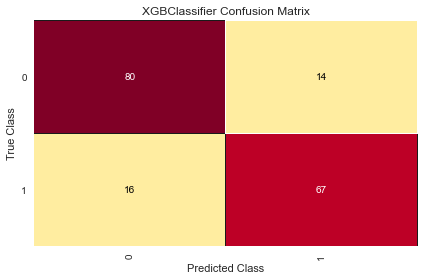

In [42]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import ConfusionMatrix

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(xgb_classifier)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show();

# Tuning XGBoost

In [44]:
xgb = XGBClassifier()

In [45]:
xgb_params = {"n_estimators": [50, 100, 300],
             "subsample":[0.5,0.8,1],
             "max_depth":[3,5,7],
             "learning_rate":[0.1,0.01,0.3]}

In [46]:
xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 2, 
                            n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 139 out of 162 | elapsed:    7.5s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:    7.7s finished


In [47]:
xgb_cv_model.best_params_

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

In [48]:
xgb_tuned = XGBClassifier(learning_rate= 0.01, 
                                max_depth= 3, 
                                n_estimators= 50, 
                                subsample= 0.8).fit(X_train, y_train)

In [51]:
y_pred = xgb_tuned.predict(X_test)

In [54]:
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_accuracy

0.8248587570621468

In [52]:
xgb_f1_tuned = f1_score(y_test, y_pred, average='macro')
xgb_f1_tuned

0.8234158272455187

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        94
           1       0.83      0.78      0.81        83

    accuracy                           0.82       177
   macro avg       0.83      0.82      0.82       177
weighted avg       0.83      0.82      0.82       177



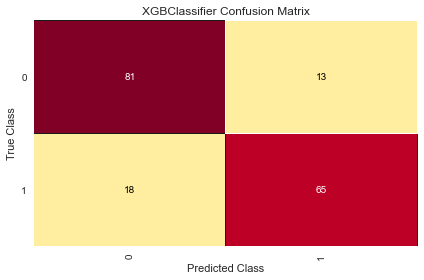

In [53]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import ConfusionMatrix

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(xgb_tuned)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show();

# Random Forest Algorithm

In [56]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [57]:
y_pred_rf = rf_model.predict(X_test)

In [58]:
rf_f1 = f1_score(y_test, y_pred_rf, average='macro')
rf_f1

0.8185080748526019

In [60]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        94
           1       0.81      0.81      0.81        83

    accuracy                           0.82       177
   macro avg       0.82      0.82      0.82       177
weighted avg       0.82      0.82      0.82       177



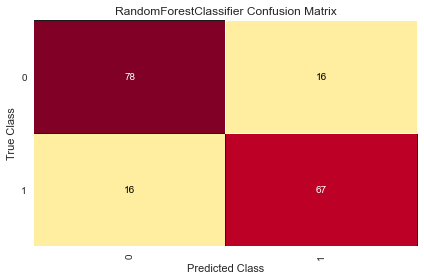

In [59]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split as tts
from yellowbrick.classifier import ConfusionMatrix

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(rf_model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show();

# Tuning Random Forest

In [61]:
rf = RandomForestClassifier()

In [62]:
rf_params = {"n_estimators":[50, 100, 300],
              "max_depth":[3,5,7],
              "max_features": [2,4,6,8],
              "min_samples_split": [2,4,6]}

In [63]:
rf_cv_model = GridSearchCV(rf, rf_params, cv = 5, n_jobs = -1, verbose = 2).fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   30.1s finished


In [64]:
rf_cv_model.best_params_

{'max_depth': 3, 'max_features': 4, 'min_samples_split': 2, 'n_estimators': 50}

In [65]:
rf_tuned = RandomForestClassifier(max_depth = 3,             
                                  max_features = 4, 
                                  min_samples_split = 2, 
                                  n_estimators = 50).fit(X_train, y_train)

In [66]:
y_pred = rf_tuned.predict(X_test)

In [67]:
rf_f1_tuned = f1_score(y_test, y_pred, average='macro')
rf_f1_tuned

0.8234158272455187

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84        94
           1       0.83      0.78      0.81        83

    accuracy                           0.82       177
   macro avg       0.83      0.82      0.82       177
weighted avg       0.83      0.82      0.82       177



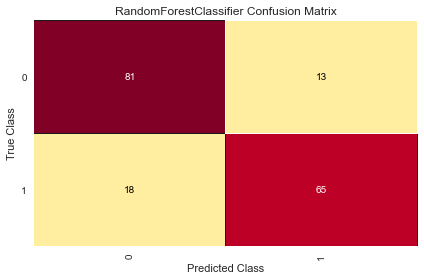

In [69]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(rf_tuned)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show();

# Decision Tree

In [70]:
modelTree = DecisionTreeClassifier()

In [71]:
modelTree.fit(X_train , y_train)

DecisionTreeClassifier()

In [72]:
y_pred = modelTree.predict(X_test)

In [73]:
tree_f1 = f1_score(y_test, y_pred, average='macro')
tree_f1

0.7713769051924566

In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80        94
           1       0.79      0.71      0.75        83

    accuracy                           0.77       177
   macro avg       0.78      0.77      0.77       177
weighted avg       0.78      0.77      0.77       177



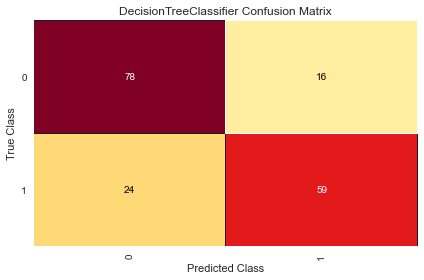

In [76]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(modelTree)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show();

# Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression
#Initalize the classifier
clf = LogisticRegression(random_state=0)
#Fitting the training data
clf.fit(X_train, y_train)
#Predicting on test
y_pred=clf.predict(X_test)

In [84]:
clf_f1 = f1_score(y_test, y_pred, average='macro')
clf_f1

0.8071648295308895

In [83]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        94
           1       0.80      0.80      0.80        83

    accuracy                           0.81       177
   macro avg       0.81      0.81      0.81       177
weighted avg       0.81      0.81      0.81       177



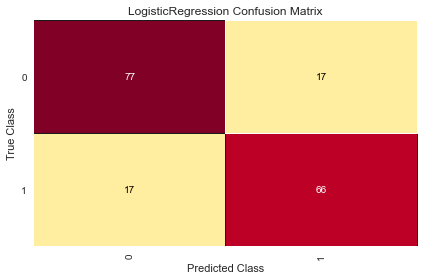

In [82]:
# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(clf)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show();

Text(0.5, 1.0, 'F1 Score of Different Models')

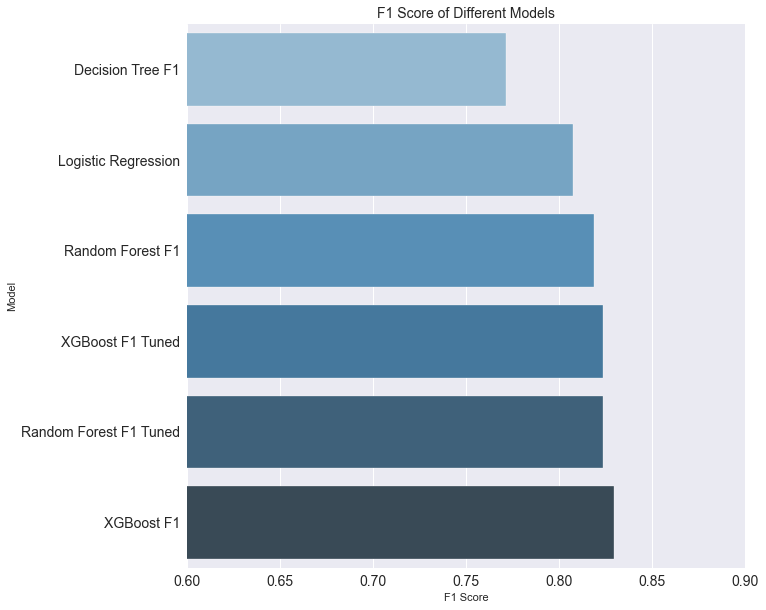

In [87]:
compare = pd.DataFrame({"Model": ["XGBoost F1", "XGBoost F1 Tuned", "Random Forest F1",
                                  "Random Forest F1 Tuned","Logistic Regression","Decision Tree F1"],
                        "F1 Score": [xgb_f1, xgb_f1_tuned, rf_f1, rf_f1_tuned, clf_f1,tree_f1]})

compare = compare.sort_values(by="F1 Score", ascending=True)

plt.figure(figsize=(10,10))
ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
ax.set_xlim(.60, .90)
plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("F1 Score of Different Models", size=14)